In [1]:
from ranx import Run, evaluate, fuse
import numpy as np

In [2]:
import joblib

search_results = joblib.load("../workdir/rerank_ws/search_results.pkl.gz")
# search_results = joblib.load("../workdir/rerank_ws/search_results_debug.pkl.gz")

In [3]:
search_results[0]["indexes"].shape

(1992, 500)

In [4]:
jacket_size = search_results[0]["indexes"].shape[0]
jacket_size

1992

In [5]:
runs = []
for search_result in search_results:
    name = search_result["name"]
    print(name)
    scores = search_result["scores"]
    # score が高いほど良い、にするために反転
    scores = np.abs(search_result["scores"] - 1.0)
    indexes = search_result["indexes"]
    run_dict = {}
    for id, (score, index) in enumerate(zip(scores, indexes)):
        id = str(id)
        # score = score.tolist()
        # index = index.tolist()
        index_score_dict = {}
        for s, i in zip(score, index):
            index_score_dict[str(i)] = s
        run_dict[id] = index_score_dict
    run = Run(run_dict, name=name)
    runs.append(run)

intfloat/multilingual-e5-large
cl-nagoya/sup-simcse-ja-base
pkshatech/GLuCoSE-base-ja
text-embedding-3-small-dim512


In [6]:
combined_run = fuse(
    runs=runs,  # A list of Run instances to fuse
    norm="min-max",  # The normalization strategy to apply before fusion
    method="rrf",  # The fusion algorithm to use
)

In [7]:
combined_data = combined_run.to_dict()

In [8]:
len(combined_data)

1992

In [9]:
len(combined_data["0"])

1460

In [10]:
import json
import os
import re
import time
import urllib.request
from argparse import ArgumentParser
from dataclasses import dataclass
from functools import lru_cache
from pathlib import Path
from time import time

import faiss
import numpy as np
import pandas as pd
import torch
from datasets import load_dataset  # type: ignore
from datasets.download import DownloadManager
from langchain_openai import OpenAIEmbeddings
from sentence_transformers import CrossEncoder, SentenceTransformer
from tqdm import tqdm


JAQKET_V1_DEV_URLS = [
    "https://jaqket.s3.ap-northeast-1.amazonaws.com/data/aio_01/dev1_questions.json",
    "https://jaqket.s3.ap-northeast-1.amazonaws.com/data/aio_01/dev2_questions.json",
]


WIKIPEDIA_JA_DS = "singletongue/wikipedia-utils"
WIKIPEDIA_JS_DS_NAME = "passages-c400-jawiki-20230403"
WIKIPEDIA_JA_EMB_DS = "hotchpotch/wikipedia-passages-jawiki-embeddings"


def get_wikija_ds(name: str = WIKIPEDIA_JS_DS_NAME):
    ds = load_dataset(path=WIKIPEDIA_JA_DS, name=name, split="train")  # type: ignore
    return ds


# jaqket v1
@dataclass
class JaqketQuestionV1:
    qid: str
    question: str
    answer_entity: str
    label: int
    answer_candidates: list[str]
    original_question: str


def load_jaqket_v1(urls):
    res: list[JaqketQuestionV1] = []
    for url in urls:
        with urllib.request.urlopen(url) as f:
            # f は 1行ごとに処理
            data = [json.loads(line.decode("utf-8")) for line in f]
        for d in data:
            # label position
            d["label"] = d["answer_candidates"].index(d["answer_entity"])
            # if -1
            if d["label"] == -1:
                raise ValueError(
                    f"answer_entity not found in answer_candidates: {d['answer_entity']}, {d['answer_candidates']}"
                )
            res.append(
                JaqketQuestionV1(
                    qid=d["qid"],
                    question=d["question"],
                    answer_entity=d["answer_entity"],
                    label=d["label"],
                    answer_candidates=d["answer_candidates"],
                    original_question=d["original_question"],
                )
            )
    return res


print("load wikija datasets")
ds = get_wikija_ds()

jacket_v1 = load_jaqket_v1(JAQKET_V1_DEV_URLS)

load wikija datasets


In [11]:
jacket_v1 = jacket_v1[:jacket_size]

In [12]:
found_indexes = []
for i, jacket in enumerate(jacket_v1):
    # print("")
    # print(jacket.question)
    # print(jacket.answer_entity)
    found_index = -1
    rank_data = combined_data[str(i)]
    for rank_idx, (k, v) in enumerate(rank_data.items()):
        ds_index = int(k)
        target_data = ds[ds_index]
        join_text = target_data["title"] + target_data["text"]
        if jacket.answer_entity in join_text:
            found_index = rank_idx
            break
    found_indexes.append(found_index)

In [13]:
# index が -1の要素を数える
print(len([i for i in found_indexes if i == -1]))

12


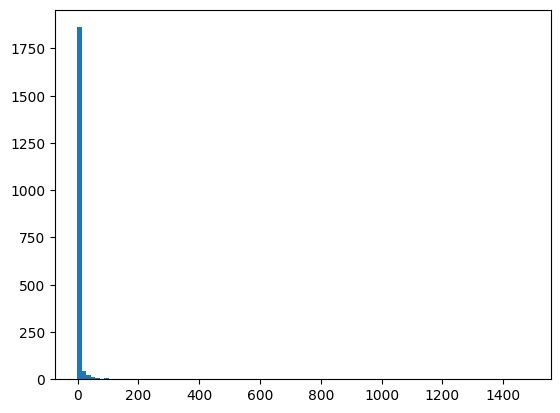

In [14]:
# plt hist
import matplotlib.pyplot as plt

plt.hist(found_indexes, bins=100)
plt.show()

In [15]:
# pd
import pandas as pd

# percentile

pd.Series(found_indexes).describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.85, 0.9])

count    1992.000000
mean       10.269076
std        74.852065
min        -1.000000
10%         0.000000
25%         0.000000
50%         0.000000
75%         2.000000
85%         4.000000
90%         8.000000
max      1483.000000
dtype: float64

In [16]:
# ds の正解ラベルを取得

acc_labels_dict = {}
for i, jacket in enumerate(jacket_v1):
    rank_data = combined_data[str(i)]
    acc_labels = {}
    for rank_idx, (k, v) in enumerate(rank_data.items()):
        ds_index = int(k)
        target_data = ds[ds_index]
        join_text = target_data["title"] + " " + target_data["text"]
        if jacket.answer_entity in join_text:
            acc_labels[k] = 1
    acc_labels_dict[str(i)] = acc_labels

In [17]:
list(runs[0]["0"].items())[0:10]

[('1458038', 0.7336907386779785),
 ('1458041', 0.7181362509727478),
 ('1458036', 0.7163646221160889),
 ('28114', 0.713198721408844),
 ('4569666', 0.7079364061355591),
 ('30925', 0.7020142078399658),
 ('1458037', 0.7001501321792603),
 ('268525', 0.6970439553260803),
 ('28111', 0.6969540119171143),
 ('5279', 0.6942585706710815)]

In [18]:
list(acc_labels_dict["0"].items())[0:10]

[('1458036', 1),
 ('1458038', 1),
 ('923871', 1),
 ('1458041', 1),
 ('3026675', 1),
 ('1458037', 1),
 ('1458042', 1),
 ('4516340', 1),
 ('327425', 1),
 ('1458039', 1)]

In [19]:
from ranx import evaluate, Qrels

qrels = Qrels(acc_labels_dict)

In [20]:
evaluate(qrels, runs[0], "ndcg@100")

0.40775441546861135

In [21]:
runs[0].name, evaluate(qrels, runs[0], "hit_rate@100")

('intfloat/multilingual-e5-large', 0.9784136546184738)

In [22]:
from ranx import compare

# Compare different runs and perform statistical tests
report = compare(
    qrels=qrels,
    runs=runs,
    metrics=[
        "map@100",
        "mrr@100",
        "ndcg@10",
        "ndcg@100",
        "hit_rate@1",
        "hit_rate@5",
        "hit_rate@20",
        "hit_rate@100",
        "hit_rate@500",
    ],
    max_p=0.01,  # P-value threshold
)
print(report.to_table())

#    Model                           MAP@100    MRR@100    NDCG@10    NDCG@100    Hit Rate@1    Hit Rate@5    Hit Rate@20    Hit Rate@100    Hit Rate@500
---  ------------------------------  ---------  ---------  ---------  ----------  ------------  ------------  -------------  --------------  --------------
a    intfloat/multilingual-e5-large  0.188ᵇᶜᵈ   0.781ᵇᶜᵈ   0.486ᵇᶜᵈ   0.408ᵇᶜᵈ    0.695ᵇᶜᵈ      0.894ᵇᶜᵈ      0.953ᵇᶜᵈ       0.978ᵇᶜᵈ        0.990ᵇᶜᵈ
b    cl-nagoya/sup-simcse-ja-base    0.098ᶜᵈ    0.558ᶜ     0.294ᶜᵈ    0.259ᶜᵈ     0.448ᶜ        0.692         0.827          0.924ᵈ          0.973
c    pkshatech/GLuCoSE-base-ja       0.078      0.527      0.272      0.222ᵈ      0.410         0.669         0.811          0.911           0.964
d    text-embedding-3-small-dim512   0.077      0.547      0.275      0.212       0.441         0.673         0.808          0.904           0.970


In [23]:
from ranx import fuse, evaluate, optimize_fusion


# Optimize a given fusion method
best_params = optimize_fusion(
    qrels=qrels,
    runs=runs,
    norm="min-max",  # Default value
    method="wsum",  # Alias for Weighted Sum
    metric="ndcg@100",  # Metric we want to maximize
)

combined_run = fuse(
    runs=runs,
    norm="min-max",  # Default value
    method="wsum",  # Alias for Weighted Sum
    params=best_params,
)

print(combined_run.name, evaluate(qrels, combined_run, "ndcg@100"))

Output()

weighted_sum 0.4191674252009489


In [25]:
list(combined_run.keys())["0"]

TypeError: list indices must be integers or slices, not str

In [24]:
# combined_run.keys()["0"]
""

''

In [26]:
print(combined_run.name, evaluate(qrels, combined_run, "hit_rate@100"))

weighted_sum 0.9804216867469879


In [27]:
combined_data = combined_run.to_dict()

In [28]:
combined_data["0"]

{'1458038': 0.7716371100397383,
 '28114': 0.701546325634167,
 '1458036': 0.6311026009808118,
 '4569666': 0.5810220531332259,
 '1458041': 0.5749223874134048,
 '2104489': 0.5578418729421074,
 '268525': 0.544669028177161,
 '4569668': 0.5281532094185969,
 '4569665': 0.47256655818840143,
 '30925': 0.4291126007767105,
 '28111': 0.4053379431328337,
 '1458037': 0.39378237943608607,
 '268527': 0.38910972570890123,
 '213623': 0.3868875351665332,
 '3026652': 0.3798421118819674,
 '2327158': 0.37969484422037575,
 '28112': 0.3584943666972878,
 '923871': 0.3543912502594371,
 '5279': 0.35041092877208235,
 '3022069': 0.3484925606101138,
 '3805680': 0.33117087891028196,
 '4822865': 0.32546779236881973,
 '4345628': 0.32311052365971876,
 '2696366': 0.31584920062789956,
 '1820810': 0.3124803166664136,
 '268524': 0.29473212185892333,
 '4345629': 0.2936918776054584,
 '3026666': 0.2933092126945786,
 '1547166': 0.28642538360244874,
 '4569667': 0.285705779698057,
 '3838622': 0.28172680076623724,
 '58090': 0.280